In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/train.zip -d /content

In [45]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.4 MB/s eta 0:00:00


In [46]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, metrics, optimizers, losses
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from sklearn.utils import compute_class_weight

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
base_dir = '/content/train/'
count = 0
class_counts = []

# Lấy số lượng ảnh trong từng thư mục
dirs = os.listdir(base_dir)
for dir in dirs:
    files = list(os.listdir(os.path.join(base_dir, dir)))
    count += len(files)
    class_counts.append(len(files))
    print(dir + ' folder has ' + str(len(files)) + ' images')

# In tổng số ảnh trong thư mục
print('Dataset folder has ' + str(count) + ' images in total')

venn folder has 75 images
surface folder has 155 images
heatmap folder has 197 images
line folder has 10556 images
pie folder has 242 images
scatter folder has 1350 images
vertical_bar folder has 5454 images
scatter-line folder has 1818 images
area folder has 172 images
vertical_interval folder has 489 images
map folder has 533 images
vertical_box folder has 763 images
manhattan folder has 176 images
horizontal_interval folder has 156 images
horizontal_bar folder has 787 images
Dataset folder has 22923 images in total


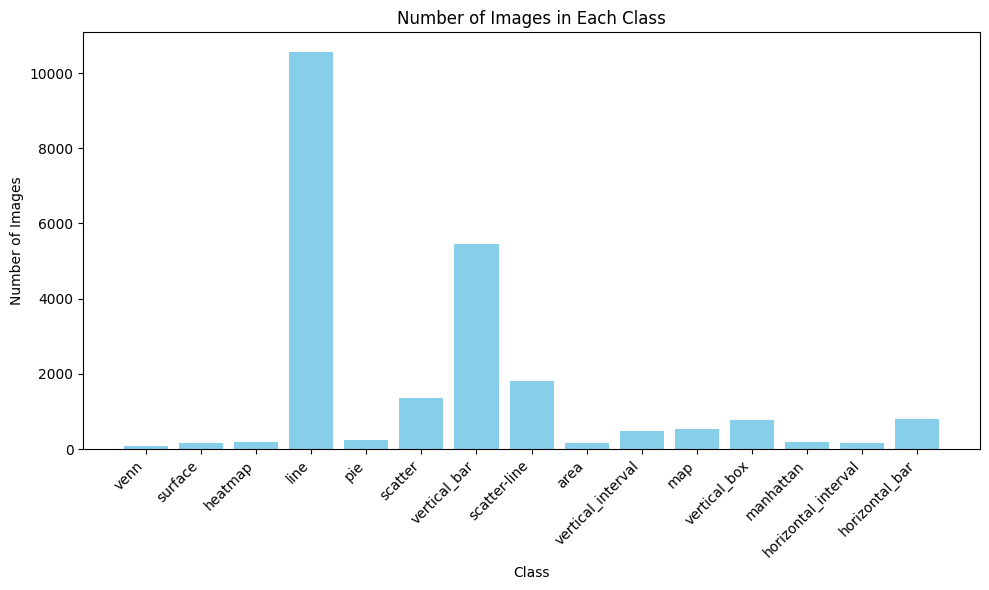

In [5]:
plt.figure(figsize=(10, 6))
plt.bar(dirs, class_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [6]:
img_size = 96
batch = 128

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'training',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))
val_ds = tf.keras.utils.image_dataset_from_directory(base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'validation',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

Found 22923 files belonging to 15 classes.
Using 18339 files for training.
Found 22923 files belonging to 15 classes.
Using 4584 files for validation.


In [8]:
class_name = train_ds.class_names
class_name

['area',
 'heatmap',
 'horizontal_bar',
 'horizontal_interval',
 'line',
 'manhattan',
 'map',
 'pie',
 'scatter',
 'scatter-line',
 'surface',
 'venn',
 'vertical_bar',
 'vertical_box',
 'vertical_interval']

In [10]:
train_labels = np.concatenate([y for x, y in train_ds], axis=0)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 8.989705882352942,
 1: 7.454878048780488,
 2: 1.8694189602446483,
 3: 9.477519379844962,
 4: 0.14434474616292797,
 5: 8.859420289855073,
 6: 2.836658932714617,
 7: 6.052475247524752,
 8: 1.1341372912801484,
 9: 0.8396978021978022,
 10: 10.021311475409837,
 11: 21.079310344827586,
 12: 0.28314034275127375,
 13: 2.0308970099667776,
 14: 3.208923884514436}

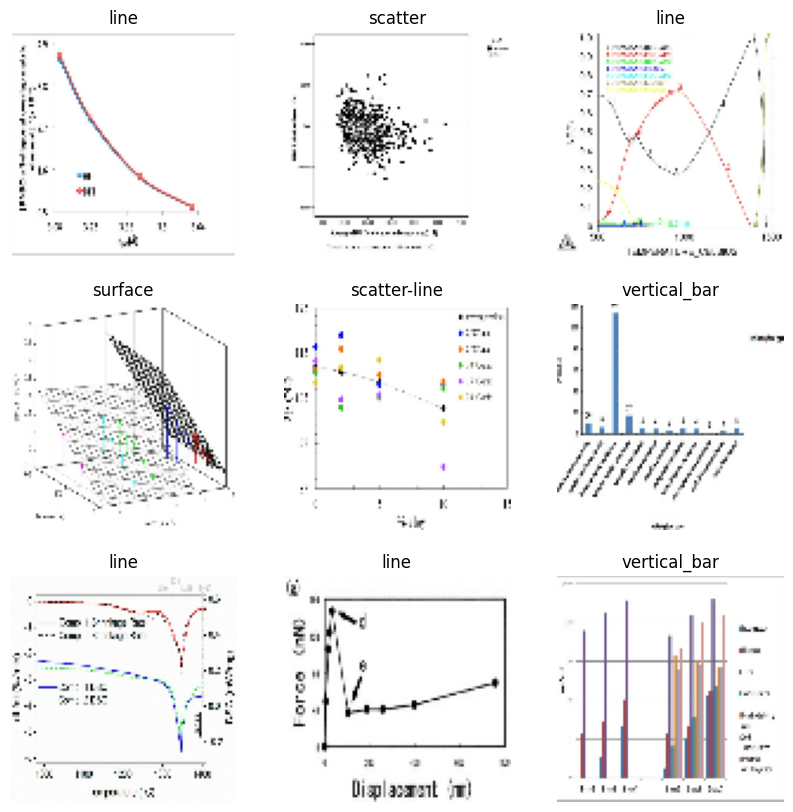

In [11]:
i = 0
plt.figure(figsize = (10,10))

for images, labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_name[labels[i]])
    plt.axis('off')

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [17]:
data_aug = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomZoom(0.1),
    layers.RandomContrast(factor=0.2),
    layers.RandomBrightness(factor=0.1),
])

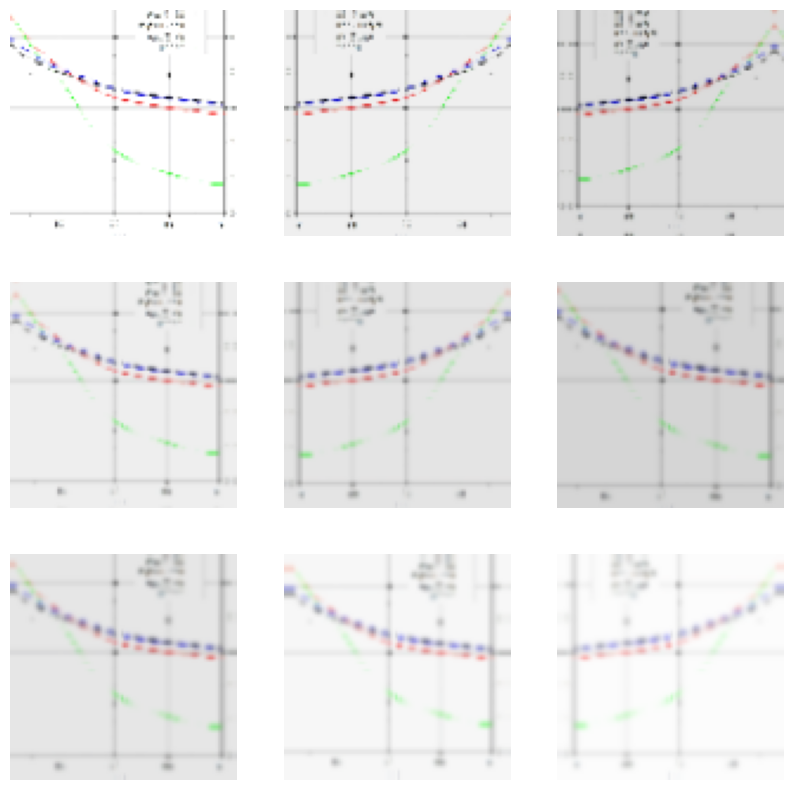

In [18]:
i = 0
plt.figure(figsize = (10,10))

for images, labels in train_ds.take(1):
  for i in range(9):
    images = data_aug(images)
    plt.subplot(3,3,i+1)
    plt.imshow(images[0].numpy().astype('uint8'))
    plt.axis('off')

In [79]:
model = Sequential([
    data_aug,
    layers.Rescaling(1./255),
    Conv2D(32, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    MaxPooling2D(pool_size = (3,3)),
    Dropout(0.2),
    Conv2D(64, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    Conv2D(64, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(0.2),
    Conv2D(128, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    Conv2D(128, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(0.2),
    Flatten(),
    Dense(1024, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    Dropout(0.2),
    Dense(15, activation = 'softmax')
])

In [66]:
class CustomF1(tf.keras.metrics.F1Score):
  def __init__(self, num_classes=1, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.num_classes = num_classes

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true_ohe = tf.one_hot(tf.reshape(y_true, [-1]), self.num_classes)
    return super().update_state(y_true_ohe, y_pred, sample_weight=sample_weight)

In [80]:
model.compile(optimizer = optimizers.Adam(learning_rate=1e-5),
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = [CustomF1(num_classes=len(class_name))])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 rescaling_6 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_30 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_36 (Ba  (None, 96, 96, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_24 (Dropout)        (None, 32, 32, 32)       

In [81]:
#callback = tf.keras.callbacks.EarlyStopping()
history = model.fit(train_ds, epochs=100, validation_data=val_ds, class_weight=class_weight_dict)

Epoch 1/100
144/144 [==============================] - 17s 88ms/step - loss: 3.2413 - f1_score: 0.0712 - val_loss: 2.9543 - val_f1_score: 0.0122
Epoch 2/100
144/144 [==============================] - 13s 87ms/step - loss: 2.7971 - f1_score: 0.1042 - val_loss: 3.0338 - val_f1_score: 0.0421
Epoch 3/100
144/144 [==============================] - 13s 90ms/step - loss: 2.5976 - f1_score: 0.1195 - val_loss: 2.7533 - val_f1_score: 0.1475
Epoch 4/100
144/144 [==============================] - 13s 90ms/step - loss: 2.4668 - f1_score: 0.1375 - val_loss: 2.5785 - val_f1_score: 0.2040
Epoch 5/100
144/144 [==============================] - 12s 87ms/step - loss: 2.2958 - f1_score: 0.1551 - val_loss: 2.3095 - val_f1_score: 0.2223
Epoch 6/100
144/144 [==============================] - 12s 86ms/step - loss: 2.2110 - f1_score: 0.1686 - val_loss: 2.1655 - val_f1_score: 0.2508
Epoch 7/100
144/144 [==============================] - 12s 87ms/step - loss: 2.1884 - f1_score: 0.1830 - val_loss: 2.1631 - val_f1

In [82]:
model.save('/content/drive/MyDrive/MyFolder/chart_VGG.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/MyFolder/chart_VGG.h5')

In [83]:
loss, f1_score = model.evaluate(val_ds, verbose=2)

144/144 - 2s - loss: 0.8471 - f1_score: 0.6747 - 2s/epoch - 14ms/step


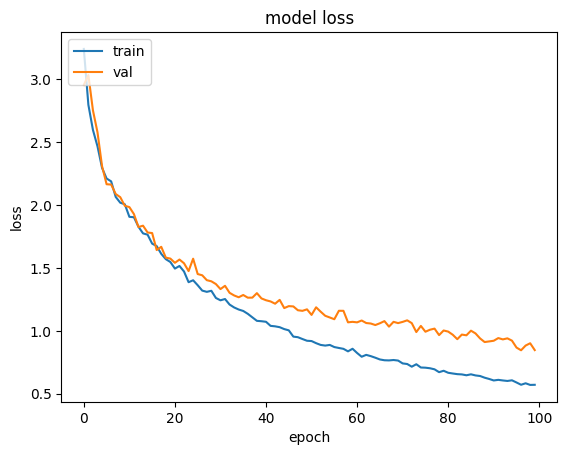

In [85]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

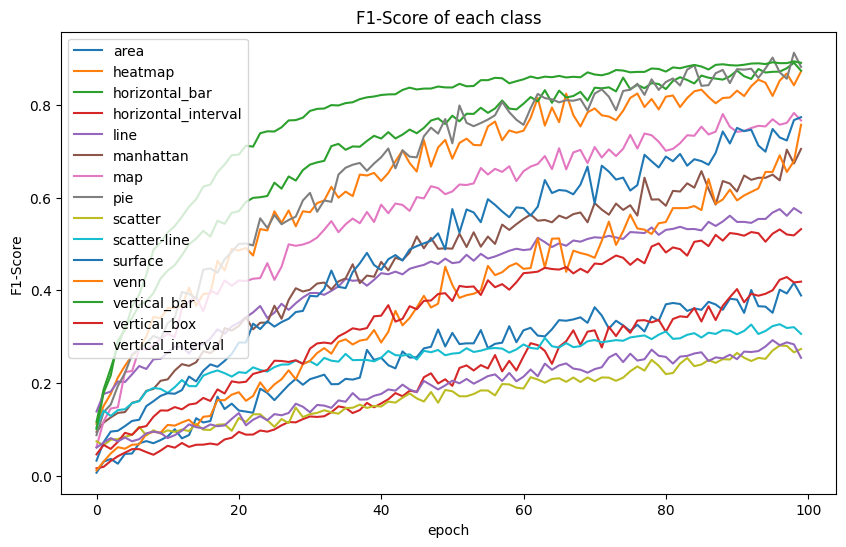

In [84]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['f1_score'])
plt.title('F1-Score of each class on training set')
plt.ylabel('F1-Score')
plt.xlabel('epoch')
plt.legend(class_name)
plt.show()

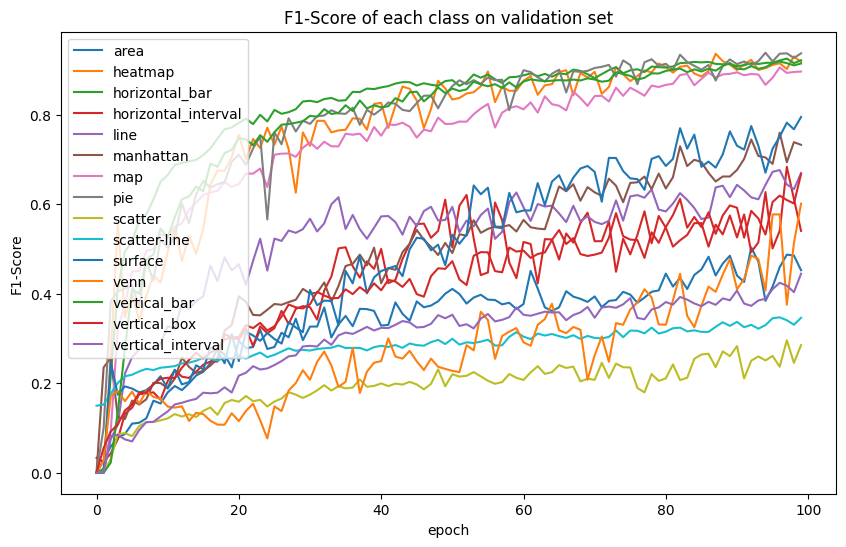

In [86]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_f1_score'])
plt.title('F1-Score of each class on validation set')
plt.ylabel('F1-Score')
plt.xlabel('epoch')
plt.legend(class_name)
plt.show()

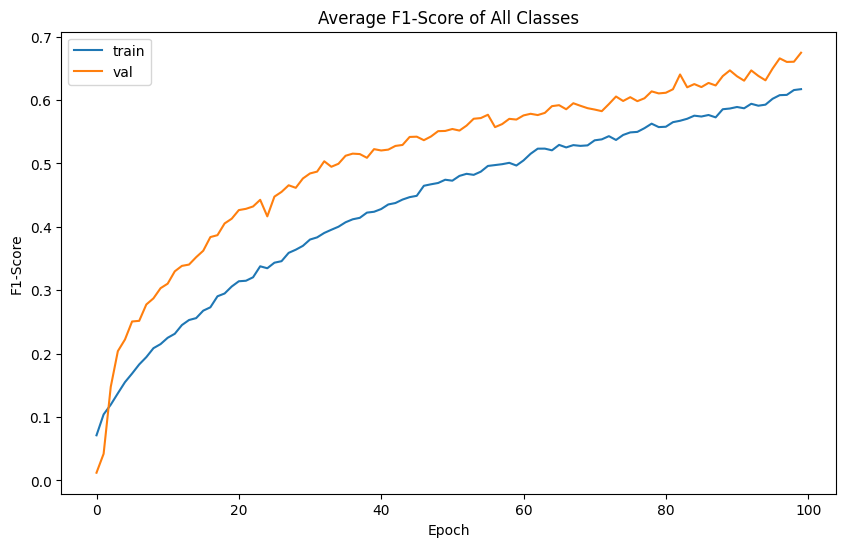

In [113]:
plt.figure(figsize=(10, 6))
plt.plot(np.mean(np.array(history.history['f1_score']), axis=1))
plt.plot(np.mean(np.array(history.history['val_f1_score']), axis=1))
plt.title('Average F1-Score of All Classes')
plt.ylabel('F1-Score')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()